In [1]:
import os

In [2]:
import torch
import torch.nn as nn
from torchvision import models
import cv2
import numpy as np

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import glob
import matplotlib.pyplot as plt

In [15]:
%matplotlib inline

In [5]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

In [6]:
def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

In [7]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes

In [8]:
def visualization_eigenCAM_resize(model,target_layers,test):
    for imgn in test:
        print(imgn)
        img = cv2.imread(imgn)
        img = cv2.resize(img, (640, 640))
        rgb_img = img.copy()
        img = np.float32(img) / 255
        transform = transforms.ToTensor()
        tensor = transform(img).unsqueeze(0)
        results = model([rgb_img])
        boxes, colors, names = parse_detections(results)
        detections = draw_detections(boxes, colors, names, rgb_img.copy())
        #plt.matshow(detections)
        #Image.fromarray(detections)
        cam = EigenCAM(model, target_layers, use_cuda=False)
        grayscale_cam = cam(tensor)[0, :, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
        renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
        #Image.fromarray(renormalized_cam_image)
        #Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5.5))
        ax1.imshow(detections)
        ax1.axis('off')
        ax2.imshow(cam_image)
        ax2.axis('off')
        ax3.imshow(renormalized_cam_image)
        ax3.axis('off')
        plt.show()
        plt.close()
        #break

In [9]:
def visualization_eigenCAM(model,target_layers,test):
    for imgn in test:
        print(imgn)
        img = cv2.imread(imgn)
        #img = cv2.resize(img, (640, 640))
        rgb_img = img.copy()
        img = np.float32(img) / 255
        transform = transforms.ToTensor()
        tensor = transform(img).unsqueeze(0)
        results = model([rgb_img])
        boxes, colors, names = parse_detections(results)
        detections = draw_detections(boxes, colors, names, rgb_img.copy())
        #plt.matshow(detections)
        #Image.fromarray(detections)
        cam = EigenCAM(model, target_layers, use_cuda=False)
        grayscale_cam = cam(tensor)[0, :, :]
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
        renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
        #Image.fromarray(renormalized_cam_image)
        #Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5.5))
        ax1.imshow(detections)
        ax1.axis('off')
        ax2.imshow(cam_image)
        ax2.axis('off')
        ax3.imshow(renormalized_cam_image)
        ax3.axis('off')
        plt.show()
        plt.close()
        #break
        

In [10]:
def saved_eigenCAM(folder,model,target_layers,test,conv):    
    for name in test:
        slice_name = name.split("/")[-1]
        img = cv2.imread(name)
        #img = cv2.resize(img, (640, 640))
        rgb_img = img.copy()
        img = np.float32(img) / 255
        transform = transforms.ToTensor()
        tensor = transform(img).unsqueeze(0)
        cam = EigenCAM(model, target_layers, use_cuda=False)
        grayscale_cam = cam(tensor)[0, :, :]
        plt.imshow(grayscale_cam)
        plt.axis('off')
        plt.savefig(f'results/{folder}/{conv}/{slice_name}',dpi=169.8,bbox_inches='tight',pad_inches=0)
        #plt.savefig("results/UC3/EigenCAM.png",dpi=169.8,bbox_inches='tight',pad_inches=0)
        print(slice_name)
        #break

In [39]:
def saved_eigenCAM_jet(folder,model,target_layers,test,conv):    
    for name in test:
        slice_name = name.split("/")[-1]
        img = cv2.imread(name)
        #img = cv2.resize(img, (640, 640))
        rgb_img = img.copy()
        img = np.float32(img) / 255
        transform = transforms.ToTensor()
        tensor = transform(img).unsqueeze(0)
        cam = EigenCAM(model, target_layers, use_cuda=False)
        grayscale_cam = cam(tensor)[0, :, :]
        plt.imshow(grayscale_cam,cmap='jet')
        plt.axis('off')
        plt.savefig(f'results/{folder}/{conv}/{slice_name}',dpi=169.8,bbox_inches='tight',pad_inches=0)
        #plt.savefig("results/UC3/EigenCAM.png",dpi=169.8,bbox_inches='tight',pad_inches=0)
        print(slice_name)
        #break

In [ ]:
def saved_eigenCAM_jet(folder,target_layers,test,conv):    
    for name in test:
        slice_name = name.split("/")[-1]
        img = cv2.imread(name)
        #img = cv2.resize(img, (640, 640))
        rgb_img = img.copy()
        img = np.float32(img) / 255
        #transform = transforms.ToTensor()
        #tensor = transform(img).unsqueeze(0)
        cam = EigenCAM(model, target_layers, use_cuda=False)
        grayscale_cam = cam(tensor)[0, :, :]
        plt.imshow(grayscale_cam,cmap='jet')
        plt.axis('off')
        plt.savefig(f'results/{folder}/{conv}/{slice_name}',dpi=169.8,bbox_inches='tight',pad_inches=0)
        #plt.savefig("results/UC3/EigenCAM.png",dpi=169.8,bbox_inches='tight',pad_inches=0)
        print(slice_name)
        #break

In [11]:
test = sorted(glob.glob('/home/dylanvr/Mi proyecto de grado/Proyecto_Guaya/datasetS/test/images/*png'))

In [12]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best_propoused.pt')
model.eval()
model.cpu()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-24 Python-3.7.11 torch-1.10.0 CPU

Fusing layers... 
jonathan summary: 157 layers, 7024342 parameters, 0 gradients, 15.7 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [13]:
target_layers23 = [model.model.model.model[-2]]

In [ ]:
visualization_eigenCAM(model,target_layers23,test)

In [27]:
target_layers20 = [model.model.model.model[20]]

In [28]:
target_layers17 = [model.model.model.model[17]]

In [31]:
folder = 'best_propoused'

In [32]:
Con_uc3 = 'UC3'

0003_P0001-90.png
0004_P0003-75.png
0012_P0008-71.png
0017_P0011-105.png
0040_P0018-110.png
0041_P0020-191.png
0043_P0023-118.png
0045_P0024-72.png
0060_P0039-123.png
0064_P0040-43.png
0071_P0043-91.png
0078_P0045-62.png
0079_P0045-83.png
0082_P0046-34.png
0088_P0047-76.png
0100_P0051-95.png
0101_P0052-84.png
0107_P0055-91.png
0109_P0056-80.png
0117_P0060-87.png
0125_P0064-78.png
0127_P0066-449.png
0142_P0075-161.png
0147_P0080-82.png
0148_P0080-99.png
0151_P0082-173.png
0153_P0083-115.png
0156_P0084-124.png
0161_P0088-183.png
0163_P0090-100.png
0165_P0091-101.png
0170_P0092-212.png
0172_P0094-304.png
0173_P0095-194.png
0178_P0099-80.png
0184_P0111-73.png
0189_P0114-89.png
0208_P0124-90.png
0210_P0126-88.png
0214_P0129-51.png
0217_P0129-81.png
0230_P0133-136.png
0231_P0135-51.png
0241_P0141-204.png
0244_P0142-99.png
0249_P0144-65.png
0251_P0145-61.png
0260_P0152-60.png
0265_P0159-74.png
0266_P0160-51.png
0267_P0160-65.png
0268_P0160-65.png
0271_P0161-73.png
0277_P0164-122.png
0278_P016

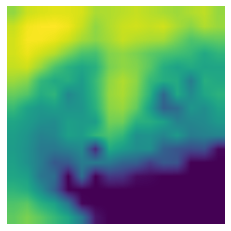

In [35]:
saved_eigenCAM(folder,model,target_layers23,test,Con_uc3)

In [33]:
Con_pc3 = 'PC3'

0003_P0001-90.png
0004_P0003-75.png
0012_P0008-71.png
0017_P0011-105.png
0040_P0018-110.png
0041_P0020-191.png
0043_P0023-118.png
0045_P0024-72.png
0060_P0039-123.png
0064_P0040-43.png
0071_P0043-91.png
0078_P0045-62.png
0079_P0045-83.png
0082_P0046-34.png
0088_P0047-76.png
0100_P0051-95.png
0101_P0052-84.png
0107_P0055-91.png
0109_P0056-80.png
0117_P0060-87.png
0125_P0064-78.png
0127_P0066-449.png
0142_P0075-161.png
0147_P0080-82.png
0148_P0080-99.png
0151_P0082-173.png
0153_P0083-115.png
0156_P0084-124.png
0161_P0088-183.png
0163_P0090-100.png
0165_P0091-101.png
0170_P0092-212.png
0172_P0094-304.png
0173_P0095-194.png
0178_P0099-80.png
0184_P0111-73.png
0189_P0114-89.png
0208_P0124-90.png
0210_P0126-88.png
0214_P0129-51.png
0217_P0129-81.png
0230_P0133-136.png
0231_P0135-51.png
0241_P0141-204.png
0244_P0142-99.png
0249_P0144-65.png
0251_P0145-61.png
0260_P0152-60.png
0265_P0159-74.png
0266_P0160-51.png
0267_P0160-65.png
0268_P0160-65.png
0271_P0161-73.png
0277_P0164-122.png
0278_P016

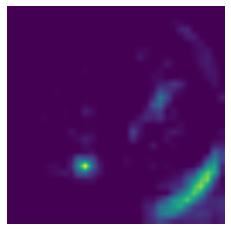

In [36]:
saved_eigenCAM(folder,model,target_layers20,test,Con_pc3)

In [34]:
Con_apc3 = 'APC3'

0003_P0001-90.png
0004_P0003-75.png
0012_P0008-71.png
0017_P0011-105.png
0040_P0018-110.png
0041_P0020-191.png
0043_P0023-118.png
0045_P0024-72.png
0060_P0039-123.png
0064_P0040-43.png
0071_P0043-91.png
0078_P0045-62.png
0079_P0045-83.png
0082_P0046-34.png
0088_P0047-76.png
0100_P0051-95.png
0101_P0052-84.png
0107_P0055-91.png
0109_P0056-80.png
0117_P0060-87.png
0125_P0064-78.png
0127_P0066-449.png
0142_P0075-161.png
0147_P0080-82.png
0148_P0080-99.png
0151_P0082-173.png
0153_P0083-115.png
0156_P0084-124.png
0161_P0088-183.png
0163_P0090-100.png
0165_P0091-101.png
0170_P0092-212.png
0172_P0094-304.png
0173_P0095-194.png
0178_P0099-80.png
0184_P0111-73.png
0189_P0114-89.png
0208_P0124-90.png
0210_P0126-88.png
0214_P0129-51.png
0217_P0129-81.png
0230_P0133-136.png
0231_P0135-51.png
0241_P0141-204.png
0244_P0142-99.png
0249_P0144-65.png
0251_P0145-61.png
0260_P0152-60.png
0265_P0159-74.png
0266_P0160-51.png
0267_P0160-65.png
0268_P0160-65.png
0271_P0161-73.png
0277_P0164-122.png
0278_P016

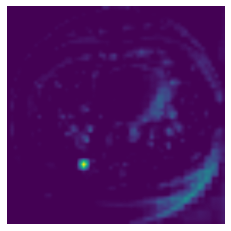

In [37]:
saved_eigenCAM(folder,model,target_layers17,test,Con_apc3)

In [40]:
Con_apc3_jet = 'APC3JET'

In [43]:
Con_pc3_jet = 'PC3JET'

In [44]:
Con_uc3_jet = 'UC3JET'

0003_P0001-90.png
0004_P0003-75.png
0012_P0008-71.png
0017_P0011-105.png
0040_P0018-110.png
0041_P0020-191.png
0043_P0023-118.png
0045_P0024-72.png
0060_P0039-123.png
0064_P0040-43.png
0071_P0043-91.png
0078_P0045-62.png
0079_P0045-83.png
0082_P0046-34.png
0088_P0047-76.png
0100_P0051-95.png
0101_P0052-84.png
0107_P0055-91.png
0109_P0056-80.png
0117_P0060-87.png
0125_P0064-78.png
0127_P0066-449.png
0142_P0075-161.png
0147_P0080-82.png
0148_P0080-99.png
0151_P0082-173.png
0153_P0083-115.png
0156_P0084-124.png
0161_P0088-183.png
0163_P0090-100.png
0165_P0091-101.png
0170_P0092-212.png
0172_P0094-304.png
0173_P0095-194.png
0178_P0099-80.png
0184_P0111-73.png
0189_P0114-89.png
0208_P0124-90.png
0210_P0126-88.png
0214_P0129-51.png
0217_P0129-81.png
0230_P0133-136.png
0231_P0135-51.png
0241_P0141-204.png
0244_P0142-99.png
0249_P0144-65.png
0251_P0145-61.png
0260_P0152-60.png
0265_P0159-74.png
0266_P0160-51.png
0267_P0160-65.png
0268_P0160-65.png
0271_P0161-73.png
0277_P0164-122.png
0278_P016

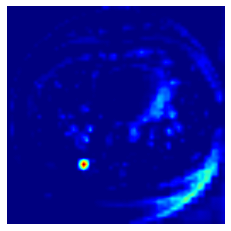

In [45]:
saved_eigenCAM_jet(folder,model,target_layers17,test,Con_apc3_jet)

0003_P0001-90.png
0004_P0003-75.png
0012_P0008-71.png
0017_P0011-105.png
0040_P0018-110.png
0041_P0020-191.png
0043_P0023-118.png
0045_P0024-72.png
0060_P0039-123.png
0064_P0040-43.png
0071_P0043-91.png
0078_P0045-62.png
0079_P0045-83.png
0082_P0046-34.png
0088_P0047-76.png
0100_P0051-95.png
0101_P0052-84.png
0107_P0055-91.png
0109_P0056-80.png
0117_P0060-87.png
0125_P0064-78.png
0127_P0066-449.png
0142_P0075-161.png
0147_P0080-82.png
0148_P0080-99.png
0151_P0082-173.png
0153_P0083-115.png
0156_P0084-124.png
0161_P0088-183.png
0163_P0090-100.png
0165_P0091-101.png
0170_P0092-212.png
0172_P0094-304.png
0173_P0095-194.png
0178_P0099-80.png
0184_P0111-73.png
0189_P0114-89.png
0208_P0124-90.png
0210_P0126-88.png
0214_P0129-51.png
0217_P0129-81.png
0230_P0133-136.png
0231_P0135-51.png
0241_P0141-204.png
0244_P0142-99.png
0249_P0144-65.png
0251_P0145-61.png
0260_P0152-60.png
0265_P0159-74.png
0266_P0160-51.png
0267_P0160-65.png
0268_P0160-65.png
0271_P0161-73.png
0277_P0164-122.png
0278_P016

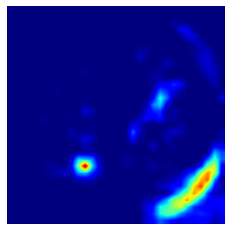

In [46]:
saved_eigenCAM_jet(folder,model,target_layers20,test,Con_pc3_jet)

0003_P0001-90.png
0004_P0003-75.png
0012_P0008-71.png
0017_P0011-105.png
0040_P0018-110.png
0041_P0020-191.png
0043_P0023-118.png
0045_P0024-72.png
0060_P0039-123.png
0064_P0040-43.png
0071_P0043-91.png
0078_P0045-62.png
0079_P0045-83.png
0082_P0046-34.png
0088_P0047-76.png
0100_P0051-95.png
0101_P0052-84.png
0107_P0055-91.png
0109_P0056-80.png
0117_P0060-87.png
0125_P0064-78.png
0127_P0066-449.png
0142_P0075-161.png
0147_P0080-82.png
0148_P0080-99.png
0151_P0082-173.png
0153_P0083-115.png
0156_P0084-124.png
0161_P0088-183.png
0163_P0090-100.png
0165_P0091-101.png
0170_P0092-212.png
0172_P0094-304.png
0173_P0095-194.png
0178_P0099-80.png
0184_P0111-73.png
0189_P0114-89.png
0208_P0124-90.png
0210_P0126-88.png
0214_P0129-51.png
0217_P0129-81.png
0230_P0133-136.png
0231_P0135-51.png
0241_P0141-204.png
0244_P0142-99.png
0249_P0144-65.png
0251_P0145-61.png
0260_P0152-60.png
0265_P0159-74.png
0266_P0160-51.png
0267_P0160-65.png
0268_P0160-65.png
0271_P0161-73.png
0277_P0164-122.png
0278_P016

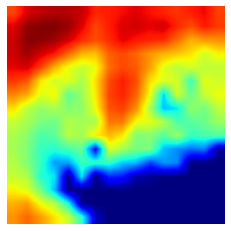

In [47]:
saved_eigenCAM_jet(folder,model,target_layers23,test,Con_pc3_jet)